In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, fbeta_score, auc,
                             classification_report, plot_confusion_matrix, roc_curve)

import imblearn
print(imblearn.__version__)

0.7.0


Since the pre-designated test dataset does not have include values for the target feature, the train dataset will be split further into a train/test set.

In [134]:
train = pd.read_csv('../data/Train.csv', index_col=0)
test = pd.read_csv('../data/Test.csv', index_col=0)

train.shape, test.shape

((13710, 44), (4570, 44))

In [135]:
train['target'] = train['target'].astype('int64')
test['target'] = test['target'].astype('int64')

In [136]:
# Split into test/train

X_train, y_train = train.drop(columns=['target', 'enrollee_id']), train.target
X_test, y_test = test.drop(columns=['target', 'enrollee_id']), test.target

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13710, 42), (13710,), (4570, 42), (4570,))

In [137]:
# Scale Data

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 0. Baseline Model

In [140]:
pd.DataFrame({
    'Counts':y_train.value_counts(),
    '%':y_train.value_counts()/len(y_train)*100
})

,Counts,%
0,10322,75.288111
1,3388,24.711889


As the majority response is 0 (most candidates are not looking for a job change), a baseline ZeroR classifier will be used as a basis of comparison for other models.

In [141]:
# Create a y_pred that is a series of 0s

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
y_pred = dummy.predict(X_test_scaled)

print(classification_report(y_pred, y_test, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.75274   0.85893      4570
           1    0.00000   0.00000   0.00000         0

    accuracy                        0.75274      4570
   macro avg    0.50000   0.37637   0.42946      4570
weighted avg    1.00000   0.75274   0.85893      4570



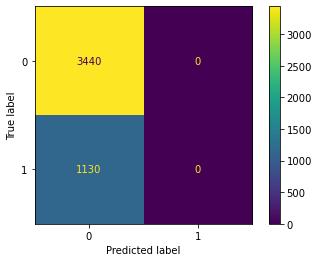

In [142]:
plot_confusion_matrix(dummy, X_test_scaled, y_test);

Baseline accuracy is 0.7527

Along with assigning class weights, another way to deal with the imabalance is oversampling candidates who are looking for a job change.

In [230]:
# SMOTE

from imblearn.over_sampling import SMOTE 

sm = SMOTE(sampling_strategy=.6, random_state=0)
X_tr_bal, y_tr_bal = sm.fit_resample(X_train, y_train)

pd.DataFrame({
    'Counts':y_tr_bal.value_counts(),
    '%':y_tr_bal.value_counts()/len(y_tr_bal)*100
})

,Counts,%
0,10322,62.500757
1,6193,37.499243


# I. Logistic Regression

In [143]:
from sklearn.linear_model import LogisticRegression

In [144]:
LR = LogisticRegression(random_state=0)

LR.fit(X_train_scaled, y_train)
y_pred = LR.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8103    0.9064    0.8557      3440
           1     0.5540    0.3540    0.4320      1130

    accuracy                         0.7698      4570
   macro avg     0.6822    0.6302    0.6438      4570
weighted avg     0.7469    0.7698    0.7509      4570



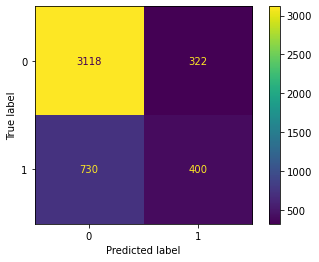

In [145]:
plot_confusion_matrix(LR, X_test_scaled, y_test);

This model performs somewhat better than the baseline. Next, I'll try to optimize performance with Grid Search cross validation

In [146]:
from sklearn.metrics import make_scorer

f05_scorer = make_scorer(fbeta_score, beta=0.5)

{0: 0.1, 1: 0.9}    47.401247
{0: 0.2, 1: 0.8}    58.962574
{0: 0.3, 1: 0.7}    61.367979
{0: 0.4, 1: 0.6}    56.149733
{0: 0.5, 1: 0.5}    43.219881
dtype: float64


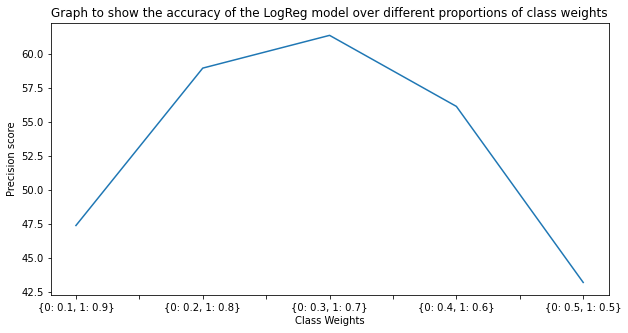

Wall time: 674 ms


In [147]:
%%time

# Print accuracy along different proportions of class weights

class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

f1 = []

for i in class_weight:
    lm = LogisticRegression(class_weight=i, random_state=0)
    lm.fit(X_train_scaled, y_train)
    f1.append(f1_score(y_test, lm.predict(X_test_scaled)) * 100)
f1 = pd.Series(f1, index=class_weight)

print(f1)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show the accuracy of the LogReg model over different proportions of class weights')
plt.xlabel('Class Weights')
plt.ylabel('Precision score')
f1.plot.line()
plt.show()

It seems that F1 is highest when class weights are 0.3 : 0.7

In [148]:
%%time

# Grid search of LR with different class weights

# Make pipeline
LR_pipeline = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])

# Define parameters
params_LR = {
    'LR__C': [0.001, 0.1, 1, 10, 100],
    'LR__penalty': ['l2', 'l1',],
    'LR__solver': ['liblinear', 'saga'],
    'LR__class_weight': class_weight
}

# Fit model
gridcv_LR = GridSearchCV(LR_pipeline, param_grid=params_LR, cv=5, scoring=f05_scorer, n_jobs=-1)
gridcv_LR.fit(X_train, y_train)

# Best model
gridcv_LR.best_estimator_, gridcv_LR.best_params_, gridcv_LR.best_score_

Wall time: 33.2 s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('LR',
                  LogisticRegression(C=10, class_weight={0: 0.4, 1: 0.6},
                                     solver='liblinear'))]),
 {'LR__C': 10,
  'LR__class_weight': {0: 0.4, 1: 0.6},
  'LR__penalty': 'l2',
  'LR__solver': 'liblinear'},
 0.5842378288110187)

In [149]:
LR_best = gridcv_LR.best_estimator_

y_pred = LR_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8553    0.8590    0.8571      3440
           1     0.5650    0.5575    0.5612      1130

    accuracy                         0.7845      4570
   macro avg     0.7102    0.7083    0.7092      4570
weighted avg     0.7835    0.7845    0.7840      4570



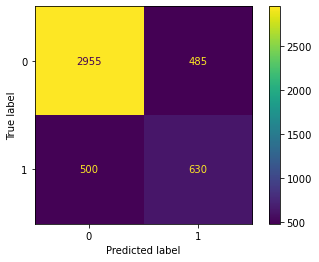

In [150]:
plot_confusion_matrix(LR_best, X_test, y_test);

The optimized logistic regression model performs about the same as the one with default settings.

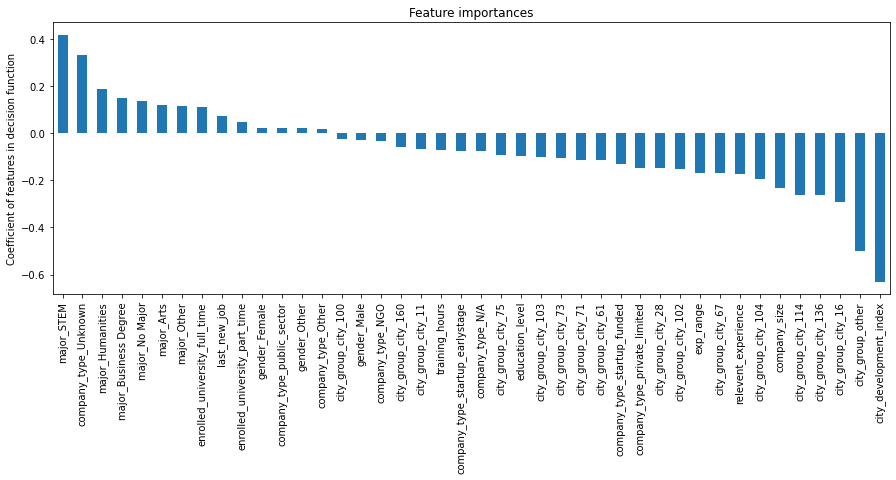

In [151]:
# Plot feature importance

importance = LR_best.named_steps.LR.coef_[0]
feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

It seems present enrollment and gender = female/other seem to be strong predictors of a positive case, with high CDI being the strongest predictor of a negative case

In [231]:
%%time

# Grid search for LR model with oversampling of minority class
from imblearn.pipeline import Pipeline as Pipe_Imb

# Make pipeline
LR_pipeline_bal = Pipe_Imb([('scaler', StandardScaler()), ('sm', SMOTE(sampling_strategy=.6)), ('LR', LogisticRegression())])

# Define parameters
params_LR_bal = {
    'LR__C': [0.001, 0.1, 1, 10, 100],
    #'LR__penalty': ['l2', 'l1',],
    #'LR__solver': ['liblinear', 'saga'],
}

# Fit model
gridcv_LR_bal = GridSearchCV(LR_pipeline_bal, param_grid=params_LR_bal, cv=5, scoring=f05_scorer, n_jobs=-1)
gridcv_LR_bal.fit(X_train, y_train)

# Best model
gridcv_LR_bal.best_estimator_, gridcv_LR_bal.best_params_, gridcv_LR_bal.best_score_

Wall time: 7.95 s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('sm', SMOTE(sampling_strategy=0.6)),
                 ('LR', LogisticRegression(C=0.1))]),
 {'LR__C': 0.1},
 0.5846328152668026)

In [232]:
LR_best_bal = gridcv_LR_bal.best_estimator_

y_pred = LR_best_bal.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8750    0.8285    0.8511      3440
           1     0.5506    0.6398    0.5919      1130

    accuracy                         0.7818      4570
   macro avg     0.7128    0.7342    0.7215      4570
weighted avg     0.7948    0.7818    0.7870      4570



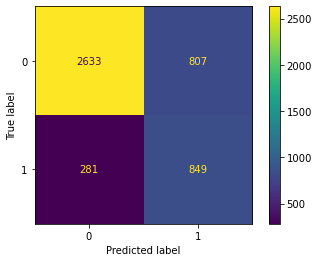

In [154]:
plot_confusion_matrix(LR_best_bal, X_test, y_test);

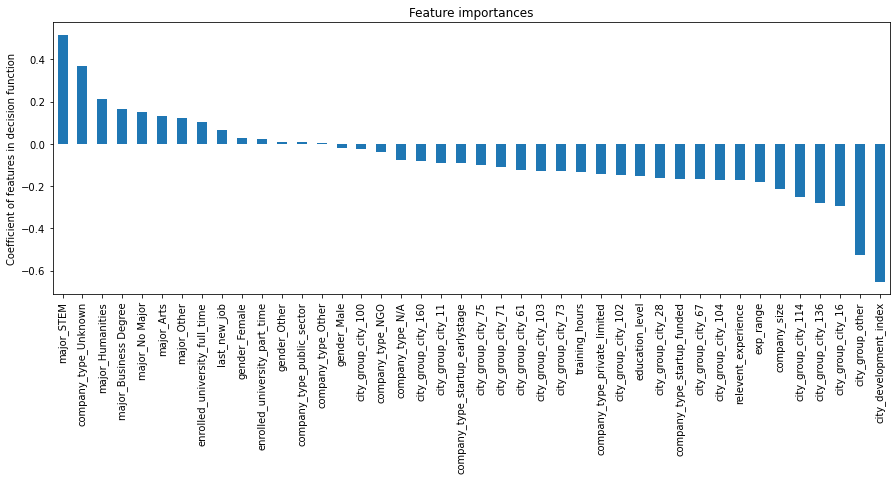

In [155]:
# Plot feature importance

importance = LR_best_bal.named_steps.LR.coef_[0]
feat_imp = pd.Series(importance, index=X_tr_bal.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

Feature importance is fairly similar to LogReg with class weights

--------------------------------------------------------------------

# II. Random Forest Classifier

In [156]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state=0)

RF.fit(X_train_scaled, y_train)
y_pred = RF.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8236    0.8797    0.8507      3440
           1     0.5379    0.4265    0.4758      1130

    accuracy                         0.7676      4570
   macro avg     0.6808    0.6531    0.6633      4570
weighted avg     0.7530    0.7676    0.7580      4570



The default RF model performs slightly worse than the LogReg models.

{0: 0.1, 1: 0.9}    47.503782
{0: 0.2, 1: 0.8}    47.984072
{0: 0.3, 1: 0.7}    47.841191
{0: 0.4, 1: 0.6}    48.696508
{0: 0.5, 1: 0.5}    47.581441
dtype: float64


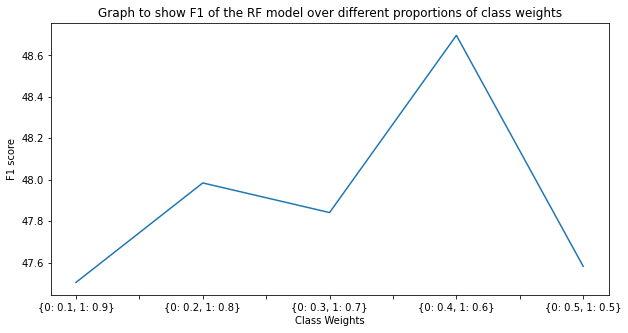

Wall time: 6.92 s


In [157]:
%%time

# Print accuracy along different proportions of class weights

class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

pr = []

for i in class_weight:
    clf = RandomForestClassifier(class_weight=i, random_state=0)
    clf.fit(X_train_scaled, y_train)
    pr.append(f1_score(y_test, clf.predict(X_test_scaled)) * 100)
pr = pd.Series(pr, index=class_weight)

print(pr)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show F1 of the RF model over different proportions of class weights')
plt.xlabel('Class Weights')
plt.ylabel('F1 score')
pr.plot.line()
plt.show()

It seems slightly under unbalanced (0.4 : 0.6) is optimal.

In [158]:
# Get a sense of the range of depths on default RF model

RF_depths = []

for i in range(len(RF.estimators_)):
    RF_depths.append(RF.estimators_[i].tree_.max_depth)
    
min(RF_depths), max(RF_depths)

(33, 47)

We can limit hyperparameter search to about this range of max depth.

In [159]:
%%time

# Make pipeline
RF_pipeline = Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier())])

# Define param grid
class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_RF = {
    'RF__n_estimators': [int(x) for x in np.linspace(start=100,stop=500,num=5)],
    'RF__max_depth': [10, 15, 20, 30, 50, 60], 
    #'RF__max_features': ['sqrt', 'log2', None], 
    #'RF__criterion': ['gini', 'entropy'],
    'RF__class_weight': class_weight
}

# Fit pipeline
RF_gridcv = GridSearchCV(RF_pipeline, params_RF, cv=5, scoring=f05_scorer, verbose=2, n_jobs=-1)
RF_gridcv.fit(X_train, y_train)

# Best model
RF_gridcv.best_estimator_, RF_gridcv.best_params_, RF_gridcv.best_score_

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Wall time: 8min 59s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('RF',
                  RandomForestClassifier(class_weight={0: 0.4, 1: 0.6},
                                         max_depth=10, n_estimators=300))]),
 {'RF__class_weight': {0: 0.4, 1: 0.6},
  'RF__max_depth': 10,
  'RF__n_estimators': 300},
 0.6014556714750015)

In [160]:
RF_best = RF_gridcv.best_estimator_

y_pred = RF_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8798    0.8424    0.8607      3440
           1     0.5752    0.6496    0.6101      1130

    accuracy                         0.7947      4570
   macro avg     0.7275    0.7460    0.7354      4570
weighted avg     0.8045    0.7947    0.7988      4570



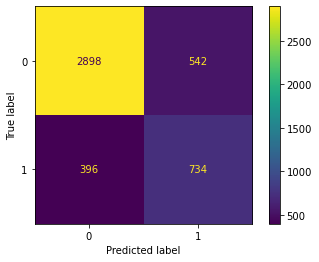

In [161]:
plot_confusion_matrix(RF_best, X_test, y_test);

The tuned model is definitely better than the default RF!

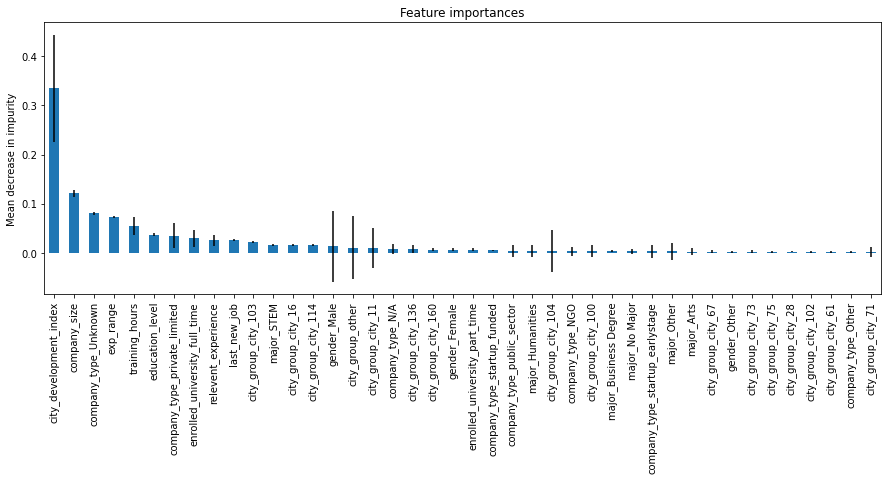

In [162]:
# Viewing feature importances

importance = RF_best.named_steps.RF.feature_importances_
forest_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in RF_best.named_steps.RF.estimators_], axis=0)

# Plot
fig, ax = plt.subplots(figsize=(15,5))

forest_imp.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=90);

In [233]:
%%time

# RF model with oversampling

# Make pipeline
RF_pipeline_bal = Pipe_Imb([('scaler', StandardScaler()),
                            ('sm', SMOTE(sampling_strategy=.6)),
                            ('RF', RandomForestClassifier())])

# Define param grid
params_RF_bal = {
    'RF__n_estimators': [int(x) for x in np.linspace(start=100,stop=500,num=5)],
    'RF__max_depth': [10, 15, 20, 30, 50, 60], 
    #'RF__max_features': ['sqrt', 'log2', None], 
    #'RF__criterion': ['gini', 'entropy'],
}

# Fit model
RF_gridcv_bal = GridSearchCV(RF_pipeline_bal, params_RF_bal, cv=5, scoring=f05_scorer, verbose=2, n_jobs=-1)
RF_gridcv_bal.fit(X_train, y_train)

# Best model
RF_gridcv_bal.best_estimator_, RF_gridcv_bal.best_params_, RF_gridcv_bal.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Wall time: 2min 19s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('sm', SMOTE(sampling_strategy=0.6)),
                 ('RF', RandomForestClassifier(max_depth=10, n_estimators=400))]),
 {'RF__max_depth': 10, 'RF__n_estimators': 400},
 0.5992622566878325)

In [234]:
RF_best_bal = RF_gridcv_bal.best_estimator_

y_pred = RF_best_bal.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8866    0.8299    0.8574      3440
           1     0.5667    0.6770    0.6169      1130

    accuracy                         0.7921      4570
   macro avg     0.7267    0.7535    0.7371      4570
weighted avg     0.8075    0.7921    0.7979      4570



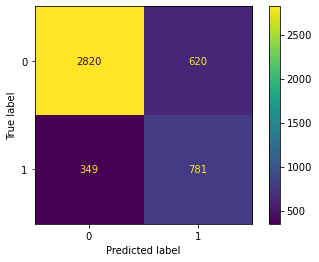

In [165]:
plot_confusion_matrix(RF_best_bal, X_test, y_test);

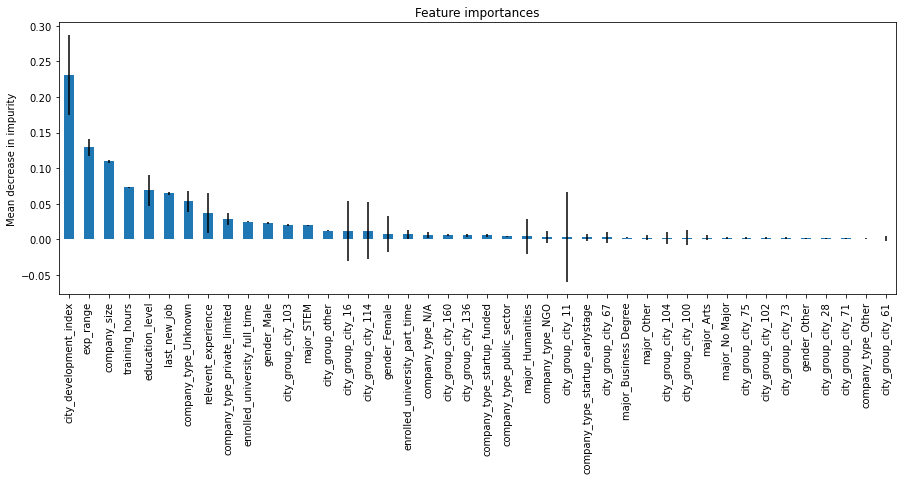

In [166]:
# Viewing feature importances

importance = RF_best_bal.named_steps.RF.feature_importances_
forest_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in RF_best_bal.named_steps.RF.estimators_], axis=0)

# Plot
fig, ax = plt.subplots(figsize=(15,5))

forest_imp.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=90);

--------------------------------------------------------------------------

# III. Support Vector Machine

### a) Linear SVC

In [167]:
from sklearn.svm import LinearSVC

In [168]:
%%time

# Define param grid
class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_SVC_lin = {
    'SVC_Linear__C': [0.01, 0.1, 1, 10, 100, 1000],
    'SVC_Linear__class_weight': class_weight,
    'SVC_Linear__max_iter': [int(x) for x in np.linspace(start=100,stop=500,num=5)],
    #'SVC_Linear__dual': [False]
}

# Grid search for optimal hyperparameters
SVC_linear = Pipeline([('scaler', StandardScaler()), ('SVC_Linear', LinearSVC(dual=False, random_state=0))])

SVC_lin_gridcv = GridSearchCV(SVC_linear, params_SVC_lin, cv=5, scoring=f05_scorer, verbose=2, n_jobs=-1)
SVC_lin_gridcv.fit(X_train, y_train)

# Best model
SVC_lin_gridcv.best_estimator_, SVC_lin_gridcv.best_params_, SVC_lin_gridcv.best_score_

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Wall time: 31.4 s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('SVC_Linear',
                  LinearSVC(C=0.01, class_weight={0: 0.4, 1: 0.6}, dual=False,
                            max_iter=100, random_state=0))]),
 {'SVC_Linear__C': 0.01,
  'SVC_Linear__class_weight': {0: 0.4, 1: 0.6},
  'SVC_Linear__max_iter': 100},
 0.5806625759778934)

In [169]:
SVC_linear_best = SVC_lin_gridcv.best_estimator_

y_pred = SVC_linear_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8512    0.8631    0.8571      3440
           1     0.5647    0.5407    0.5524      1130

    accuracy                         0.7834      4570
   macro avg     0.7079    0.7019    0.7048      4570
weighted avg     0.7804    0.7834    0.7818      4570



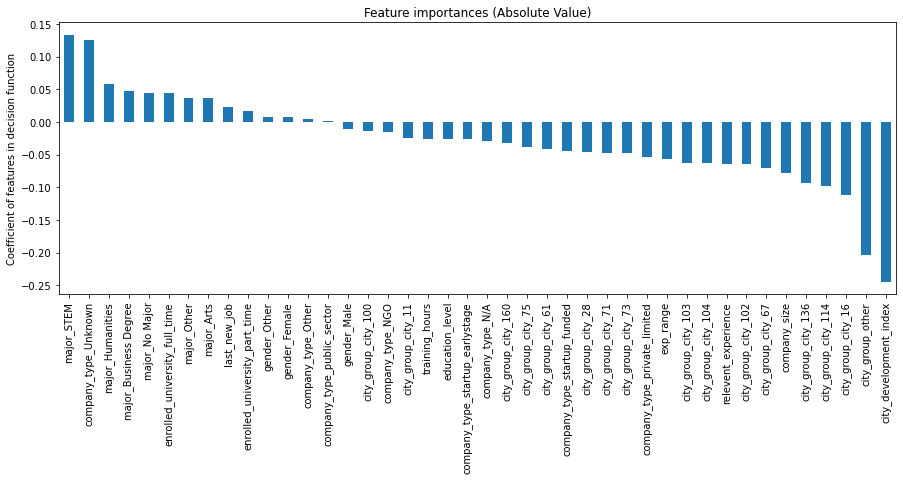

In [170]:
# Plot feature importance

importance = SVC_linear_best.named_steps.SVC_Linear.coef_[0]
feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances (Absolute Value)")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

Again, high predictors of a positive case are current university enrollment and non-male gender.

In [235]:
%%time

# SVC Linear with Oversampling of minority class

# Define param grid
params_SVC_lin_bal = {
    'SVC_Linear__C': [0.01, 0.1, 1, 10, 100, 1000],
    'SVC_Linear__max_iter': [int(x) for x in np.linspace(start=100,stop=500,num=5)],
    #'SVC_Linear__dual': [False]
}

# Grid search for optimal hyperparameters
SVC_linear_bal = Pipe_Imb([('scaler', StandardScaler()),
                       ('sm', SMOTE(sampling_strategy=.6)),
                       ('SVC_Linear', LinearSVC(dual=False, random_state=0))])

# Fit model
SVC_lin_gridcv_bal = GridSearchCV(SVC_linear_bal, params_SVC_lin_bal, cv=5, scoring=f05_scorer, verbose=2, n_jobs=-1)
SVC_lin_gridcv_bal.fit(X_train, y_train)

# Best model
SVC_lin_gridcv_bal.best_estimator_, SVC_lin_gridcv_bal.best_params_, SVC_lin_gridcv_bal.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Wall time: 17.3 s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('sm', SMOTE(sampling_strategy=0.6)),
                 ('SVC_Linear',
                  LinearSVC(C=0.1, dual=False, max_iter=300, random_state=0))]),
 {'SVC_Linear__C': 0.1, 'SVC_Linear__max_iter': 300},
 0.5854841757439271)

In [236]:
SVC_linear_best_bal = SVC_lin_gridcv_bal.best_estimator_

y_pred = SVC_linear_best_bal.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8701    0.8355    0.8524      3440
           1     0.5533    0.6204    0.5849      1130

    accuracy                         0.7823      4570
   macro avg     0.7117    0.7279    0.7187      4570
weighted avg     0.7918    0.7823    0.7863      4570



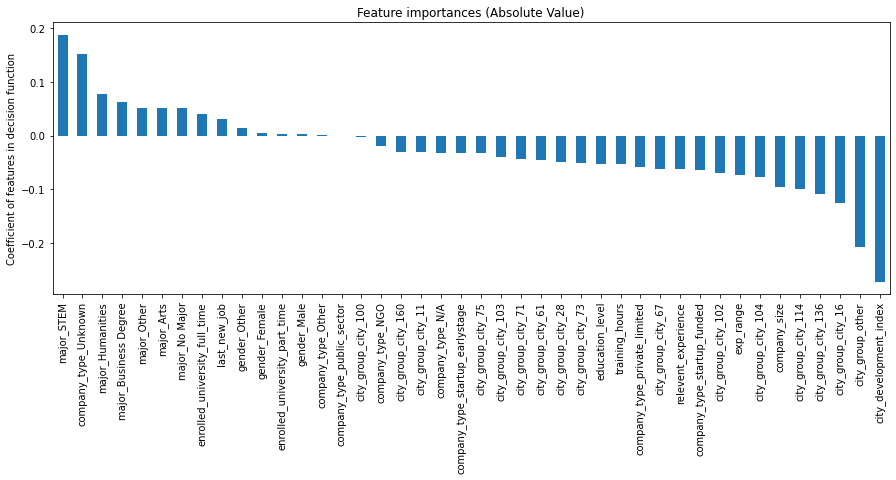

In [173]:
# Plot feature importance

importance = SVC_linear_best_bal.named_steps.SVC_Linear.coef_[0]
feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances (Absolute Value)")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

### b) SVC (nonlinear kernels)

In [174]:
from sklearn.svm import SVC

In [175]:
%%time

# Print accuracy along different values of c
c_range = [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]
pr = []

for i in c_range:
    svc = SVC(C=i, random_state=0)
    svc.fit(X_train_scaled, y_train)
    pr.append(f1_score(y_test, svc.predict(X_test_scaled)) * 100)
pr = pd.Series(pr, index=c_range)

print(pr)

0.001      0.000000
0.010      0.000000
0.100     43.708609
0.500     53.397129
1.000     55.338904
2.000     56.394035
5.000     56.672598
10.000    56.487202
dtype: float64
Wall time: 1min 41s


#### RBF Kernel

In [176]:
%%time

# Make pipeline
SVC_nonlinear = Pipeline([('scaler', StandardScaler()), ('SVC', SVC(random_state=0))])

# Define param grid
class_weight = [{0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_SVC_rbf = {
    'SVC__kernel': ['rbf'], 
    'SVC__C': [0.1, 0.5, 1, 2, 5],
    'SVC__gamma': [.0001, .001, .01, 1, 10],
    'SVC__class_weight': class_weight
}

# Grid search
SVC_rbf_gridcv = GridSearchCV(SVC_nonlinear, params_SVC_rbf, cv=5, scoring=f05_scorer, verbose=2, n_jobs=-1)
SVC_rbf_gridcv.fit(X_train, y_train)

# Best Model
SVC_rbf_gridcv.best_estimator_, SVC_rbf_gridcv.best_params_, SVC_rbf_gridcv.best_score_

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Wall time: 28min 39s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('SVC',
                  SVC(C=5, class_weight={0: 0.4, 1: 0.6}, gamma=0.01,
                      random_state=0))]),
 {'SVC__C': 5,
  'SVC__class_weight': {0: 0.4, 1: 0.6},
  'SVC__gamma': 0.01,
  'SVC__kernel': 'rbf'},
 0.5820235205227319)

In [177]:
SVC_rbf_best = SVC_rbf_gridcv.best_estimator_

y_pred = SVC_rbf_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8675    0.8448    0.8560      3440
           1     0.5623    0.6071    0.5838      1130

    accuracy                         0.7860      4570
   macro avg     0.7149    0.7259    0.7199      4570
weighted avg     0.7920    0.7860    0.7887      4570



In [237]:
%%time

# RBF with oversampling of minority class

# Make pipeline
SVC_nonlinear_bal = Pipe_Imb([('scaler', StandardScaler()),
                              ('sm', SMOTE(sampling_strategy=.6)),
                              ('SVC', SVC(random_state=0))])

# Define param grid
params_SVC_rbf_bal = {
    'SVC__kernel': ['rbf'], 
    'SVC__C': [0.1, 0.5, 1, 2, 5],
    'SVC__gamma': [.0001, .001, .01, 1, 10],
}

# Grid search
SVC_rbf_gridcv_bal = GridSearchCV(SVC_nonlinear_bal, params_SVC_rbf_bal, cv=5, scoring=f05_scorer, n_jobs=-1)
SVC_rbf_gridcv_bal.fit(X_train, y_train)

# Best Model
SVC_rbf_gridcv_bal.best_estimator_, SVC_rbf_gridcv_bal.best_params_, SVC_rbf_gridcv_bal.best_score_

Wall time: 15min 46s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('sm', SMOTE(sampling_strategy=0.6)),
                 ('SVC', SVC(C=2, gamma=0.01, random_state=0))]),
 {'SVC__C': 2, 'SVC__gamma': 0.01, 'SVC__kernel': 'rbf'},
 0.5813367947115773)

In [238]:
SVC_rbf_best_bal = SVC_rbf_gridcv_bal.best_estimator_

y_pred = SVC_rbf_best_bal.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8787    0.8294    0.8533      3440
           1     0.5563    0.6513    0.6001      1130

    accuracy                         0.7853      4570
   macro avg     0.7175    0.7403    0.7267      4570
weighted avg     0.7990    0.7853    0.7907      4570



----------------------------------------------------------------------

# IV. XGBoost Model

In [180]:
%%time

import xgboost as xgb

XGB = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=0, eval_metric='error')

XGB.fit(X_train_scaled, y_train)
y_pred = XGB.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8460    0.8622    0.8540      3440
           1     0.5545    0.5221    0.5378      1130

    accuracy                         0.7781      4570
   macro avg     0.7002    0.6922    0.6959      4570
weighted avg     0.7739    0.7781    0.7758      4570

Wall time: 595 ms


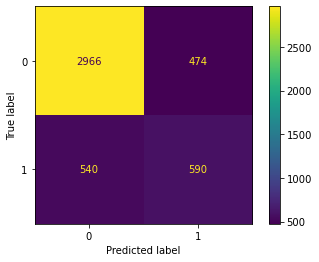

In [181]:
plot_confusion_matrix(XGB, X_test_scaled, y_test);

The default xgb model performs only slightly better than the baseline dummy model.

In [183]:
%%time

# Make pipeline
xgb_pipe = Pipeline([('scaler', StandardScaler()),
                     ('XGB', xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False,
                                               eval_metric='error', random_state=0))])

# Define param grid
params_xgb = {
    'XGB__n_estimators': [5, 10, 15, 20, 30, 40, 50], 
    'XGB__max_depth': [5, 10, 15], 
    'XGB__gamma': [2, 6, 10], 
    #'XGB__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3], 
    #'XGB__min_child_weight': [0, 1, 2, 3, 4, 5, 6, 7, 8], 
}

# Grid search
xgb_gridcv = GridSearchCV(xgb_pipe, params_xgb, cv=5, scoring=f05_scorer, n_jobs=-1)
xgb_gridcv.fit(X_train, y_train)

# Best model
xgb_gridcv.best_estimator_, xgb_gridcv.best_params_, xgb_gridcv.best_score_

Wall time: 1min 6s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('XGB',
                  XGBClassifier(base_score=0.5, booster='gbtree',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, enable_categorical=False,
                                eval_metric='error', gamma=10, gpu_id=-1,
                                importance_type=None, interaction_constraints='',
                                learning_rate=0.300000012, max_delta_step=0,
                                max_depth=10, min_child_weight=1, missing=nan,
                                monotone_constraints='()', n_estimators=5,
                                n_jobs=6, num_parallel_tree=1, predictor='auto',
                                random_state=0, reg_alpha=0, reg_lambda=1,
                                scale_pos_weight=1, subsample=1,
                                tree_method='exact', use_label_encoder=False,
                         

In [184]:
XGB_best = xgb_gridcv.best_estimator_

y_pred = XGB_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8727    0.8552    0.8639      3440
           1     0.5847    0.6204    0.6020      1130

    accuracy                         0.7972      4570
   macro avg     0.7287    0.7378    0.7329      4570
weighted avg     0.8015    0.7972    0.7991      4570



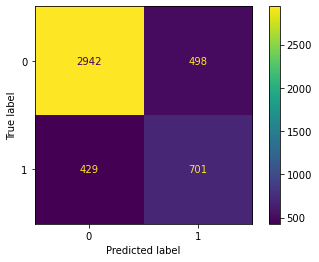

In [185]:
plot_confusion_matrix(XGB_best, X_test, y_test);

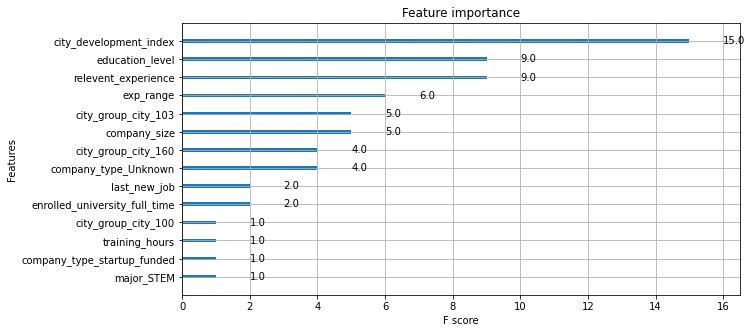

In [227]:
fig, ax = plt.subplots(figsize = (10, 5));
y = xgb.plot_importance(XGB_best.named_steps.XGB, max_num_features=None, ax=ax, importance_type='weight')

feat_idx = [0, 7, 4, 25, 31, 14, 29, 15, 23, 6, 33, 24, 18, 8]
feat_names = reversed([X_train.columns[i] for i in feat_idx])
y.set_yticklabels(feat_names);

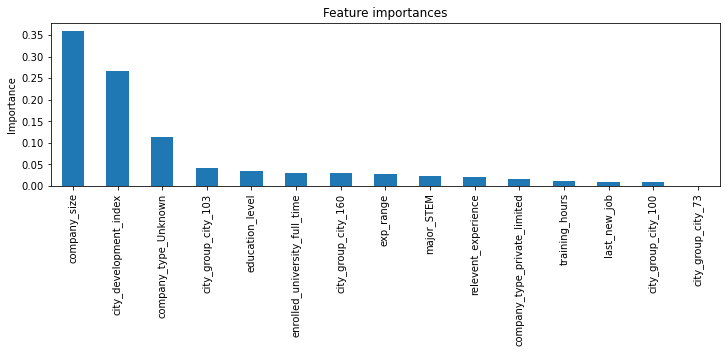

In [187]:
# Plot feature importance

importance = XGB_best.named_steps.XGB.feature_importances_
feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(12,3))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Importance")
plt.xticks(rotation=90);

In [239]:
%%time

# XGB with oversampled minority class

# Make pipeline
xgb_pipe_bal = Pipe_Imb([('scaler', StandardScaler()),
                     ('sm', SMOTE(sampling_strategy=.6)),
                     ('XGB', xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False,
                                               eval_metric='error', random_state=0))])

# Define param grid
params_xgb_bal = {
    'XGB__n_estimators': [5, 10, 15, 20, 30, 40, 50], 
    'XGB__max_depth': [5, 10, 15], 
    'XGB__gamma': [2, 6, 10], 
    #'XGB__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 
    #'XGB__min_child_weight': [0, 1, 2, 3, 4, 5, 6, 7, 8], 
}

# Grid search
xgb_gridcv_bal = GridSearchCV(xgb_pipe_bal, params_xgb_bal, cv=5, scoring=f05_scorer, n_jobs=-1)
xgb_gridcv_bal.fit(X_train, y_train)

# Best model
xgb_gridcv_bal.best_estimator_, xgb_gridcv_bal.best_params_, xgb_gridcv_bal.best_score_

Wall time: 1min 32s


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('sm', SMOTE(sampling_strategy=0.6)),
                 ('XGB',
                  XGBClassifier(base_score=0.5, booster='gbtree',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, enable_categorical=False,
                                eval_metric='error', gamma=10, gpu_id=-1,
                                importance_type=None, interaction_constraints='',
                                learning_rate=0.300000012, max_delta_step=0,
                                max_depth=15, min_child_weight=1, missing=nan,
                                monotone_constraints='()', n_estimators=15,
                                n_jobs=6, num_parallel_tree=1, predictor='auto',
                                random_state=0, reg_alpha=0, reg_lambda=1,
                                scale_pos_weight=1, subsample=1,
                                tree_method='ex

In [240]:
XGB_best_bal = xgb_gridcv_bal.best_estimator_

y_pred = XGB_best_bal.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8753    0.8451    0.8599      3440
           1     0.5733    0.6336    0.6019      1130

    accuracy                         0.7928      4570
   macro avg     0.7243    0.7393    0.7309      4570
weighted avg     0.8006    0.7928    0.7961      4570



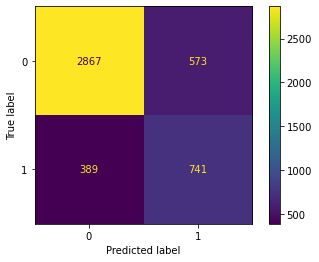

In [190]:
plot_confusion_matrix(XGB_best_bal, X_test, y_test);

----------------------------------------------------

# V. Select Best Model

In [247]:
%%time
%%capture --no-display

models = [
    ('Dummy (Baseline)', dummy),
    #('LogReg', LR),
    ('LogReg_weights', LR_best), 
    ('LogReg_oversampling', LR_best_bal),
    #('RandomForest', RF),
    ('RandomForest_weights', RF_best),
    ('RandomForest_oversampling', RF_best_bal),
    ('SVC_Linear_weights', SVC_linear_best),
    ('SVC_Linear_oversampling', SVC_linear_best_bal),
    ('SVC_RBF_weights', SVC_rbf_best),
    ('SVC_RBF_oversampling', SVC_rbf_best_bal),
    #('XGB', XGB),
    ('XGB_weights', XGB_best),
    ('XGB_best_oversampling', XGB_best_bal)
]

scoring = ['precision', 'recall', 'accuracy', 'f1', f05_scorer, 'roc_auc']

results= {}
for name, model in models:
    results[name] = {}
    for i in scoring:        
        scores = cross_validate(model, X_train, y_train, scoring=i, cv=5, return_train_score=False)
        results[name][i] = scores

Wall time: 13min 25s


In [248]:
Precision_Test = []
Recall_Test = []
Accuracy_Train = []
Accuracy_Test = []
F1_Test = []
F05_Test = []
AUC_Test = []

for model in results.keys():
    # Precision
    pr_test_mean = results[model]['precision']['test_score'].mean()*100
    Precision_Test.append(round(pr_test_mean, 2))
    
    # Recall
    rec_test_mean = results[model]['recall']['test_score'].mean()*100
    Recall_Test.append(round(rec_test_mean, 2))
    
    # Accuracy
    acc_test_mean = results[model]['accuracy']['test_score'].mean()*100
    Accuracy_Test.append(round(acc_test_mean, 2))
    
    # F05
    f05_test_mean = results[model][f05_scorer]['test_score'].mean()*100
    F05_Test.append(round(f05_test_mean, 2))
    
    # F1
    f1_test_mean = results[model]['f1']['test_score'].mean()*100
    F1_Test.append(round(f1_test_mean, 2))
    
    # AUC
    auc_test_mean = results[model]['roc_auc']['test_score'].mean()
    AUC_Test.append(round(auc_test_mean, 4))
    
# Save model names and parameters as list
names = []
steps = []
for name, model in models:
    names.append(str(name))
    if hasattr(model, 'named_steps'):
        steps.append(str(list(model.named_steps.values())[1]))
    else:
        steps.append(model)

In [249]:
#pd.options.display.max_colwidth = 100

model_compare = pd.DataFrame(
    {'Model': names,
     'Mean_Precision': Precision_Test,
     'Mean_Recall': Recall_Test,
     'Mean_Accuracy': Accuracy_Test,
     'Mean_F0.50': F05_Test,
     'Mean_F1': F1_Test,
     'Mean_AUC': AUC_Test,
     #'Parameters': steps
    }
)

model_compare

,Model,Mean_Precision,Mean_Recall,Mean_Accuracy,Mean_F0.50,Mean_F1,Mean_AUC
0,Dummy (Baseline),0.00,0.00,75.29,0.00,0.00,0.5000
1,LogReg_weights,59.16,55.67,79.54,58.42,57.36,0.7971
2,LogReg_oversampling,57.34,62.75,79.15,58.17,60.07,0.7974
3,RandomForest_weights,59.16,62.96,80.20,59.97,61.14,0.7999
4,RandomForest_oversampling,58.47,65.29,79.88,59.46,61.56,0.8012
5,SVC_Linear_weights,59.16,54.10,79.42,58.07,56.51,0.7965
6,SVC_Linear_oversampling,57.57,61.69,79.18,58.53,59.45,0.7965
7,SVC_RBF_weights,57.91,59.45,79.29,58.20,58.65,0.7896
8,SVC_RBF_oversampling,56.50,64.40,78.99,57.96,60.56,0.7915
9,XGB_weights,60.10,59.92,80.24,60.04,59.98,0.7955
